# Fourier Ptychographic Reconstruction

**overview:**

**author:** Michael Kellman

**package requirements:**


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as ag
import time

import sys
sys.path.append('./source')
from fpm import *
from pytorch_complex import *
from utility import *
from recon import *

import sigpy.plot as pl

dtype = torch.float32
np_dtype = np.float32

mul_c  = ComplexMul().apply
div_c  = ComplexDiv().apply
abs_c = ComplexAbs().apply

# setup Graphical Processing Unit
gpu_device = 2
torch.cuda.set_device(gpu_device)
device = torch.device("cuda:"+str(gpu_device) if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_properties(gpu_device)

_CudaDeviceProperties(name='TITAN X (Pascal)', major=6, minor=1, total_memory=12196MB, multi_processor_count=28)

## Load Dataset 

* simulated measurements from ground truth for amplitude-only and phase-only
* experimental data without ground truth (can consider single LED design as validation)

All datasets can be downloaded from link and placed in :


In [ ]:
# small problem for amplitude-only dataset (89 LEDS) (100 examples)
out_dir = '../Design_FPM_pytorch/datasets_train_iccp_results/'
filename = 'train_amp_exp_n10000.mat' 
dataset = FPMDataset(filename,out_dir)
specs = dataset.loadDataset()
locals().update(specs)

# small problem for phase-only dataset (89 LEDS) (100 examples)

# large problem for experimental amplitude-only dataset (1 example)

# large problem for experimental phase-only dataset (1 example)

In [30]:
Np = [int(Np[0][0]), int(Np[0][1])]
ps = ps[0][0]
wl = wl[0][0]
mag = mag[0][0]
na = na[0][0]
na_illum = na_illum[0][0]
Nleds = Nleds[0][0]
z_offset = z_offset[0][0]
print(Np,ps,mag,wl,na,na_illum,Nleds,z_offset)
pruned_na_list = na_list[:Nleds,:]
N_iter = 200

(100, 35, 35, 2) (100, 89, 35, 35) (100, 89, 35, 35)
[35, 35] 6.5 4 0.514 0.2 0.42000000000000004 89 0


## Setup Illumination Design Patterns (random or load or single LED)

<IPython.core.display.Javascript object>


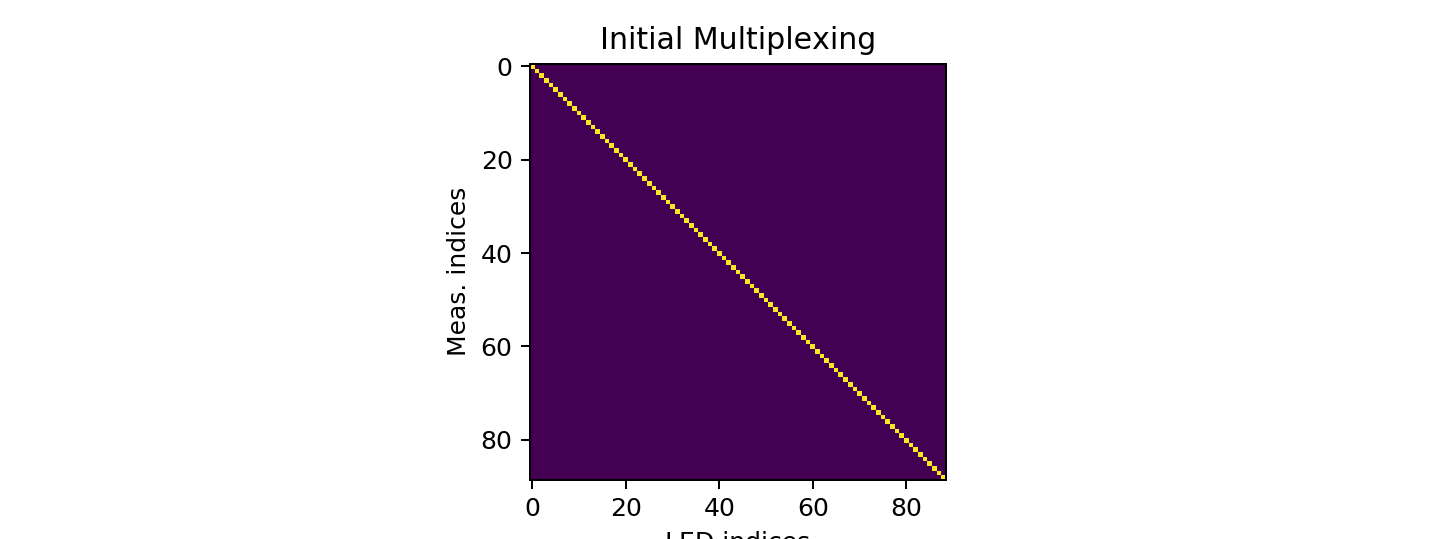

Text(0, 0.5, 'Meas. indices')

In [31]:
bands = [0,NbfLEDs,NdfLEDs]
csbands = np.cumsum(bands)
Nbands = len(bands)
NbandsMeas = [0,1,4]
Nmeas = np.sum(NbandsMeas)

# random LED Design
Nrep = np.sum(bands)
Cinit = np.random.rand(Nmeas,Nrep).astype(np_dtype)
csNbandsMeas = np.cumsum(NbandsMeas)
Nmeas = np.sum(NbandsMeas)
bandMask2 = np.zeros((Nmeas,Nleds))
for ii in range(Nbands-1):
    bandMask2[csNbandsMeas[ii]:csNbandsMeas[ii+1],csbands[ii]:csbands[ii+1]] = 1

Cinit *= bandMask2

bandMask_torch = torch.from_numpy(bandMask2.astype(np_dtype))    
bandMask_torch = bandMask_torch.to(device)

for ii in range(Nmeas):
    Cinit[ii,:] /= np.sum(Cinit[ii,:]) + 1e-5
    
# load LED Design


# single LED Design
Cinit = np.eye(Nleds).astype(np_dtype)

plt.figure(figsize=(8,3))
plt.imshow(Cinit)
plt.title('Initial Multiplexing')
plt.xlabel('LED indices')
plt.ylabel('Meas. indices')

## Setup Physics-based Model & Reconstruction

In [32]:
# setup data example
data_idx = 2
measurements,truth = dataset[data_idx]
measurements = measurements.to(device)
xtruth = truth.to(device)

# setup model
grad = FPM(Np, na, na_illum, pruned_na_list, wl, ps, mag, 
            alpha = 5e-2, maxIter = 0, C_init=Cinit, measurements=measurements, testFlag=True, T=8, device=device)
grad.to(device)

# setup reconstruction
gd_layer = GD(grad)
recon = genNetwork(gd_layer,N_iter)

Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625


## Perform Reconstruction

In [33]:
# initialization
x0 = torch.zeros(Np[0],Np[1],2,dtype=dtype,device=device)
x0[:,:,0] = measurements[0,:,:]

# perform reconstruction
out,X = feedforward(recon,x0,interFlag=False,testFlag = True,device=device)

## Display Reconstruction

<IPython.core.display.Javascript object>


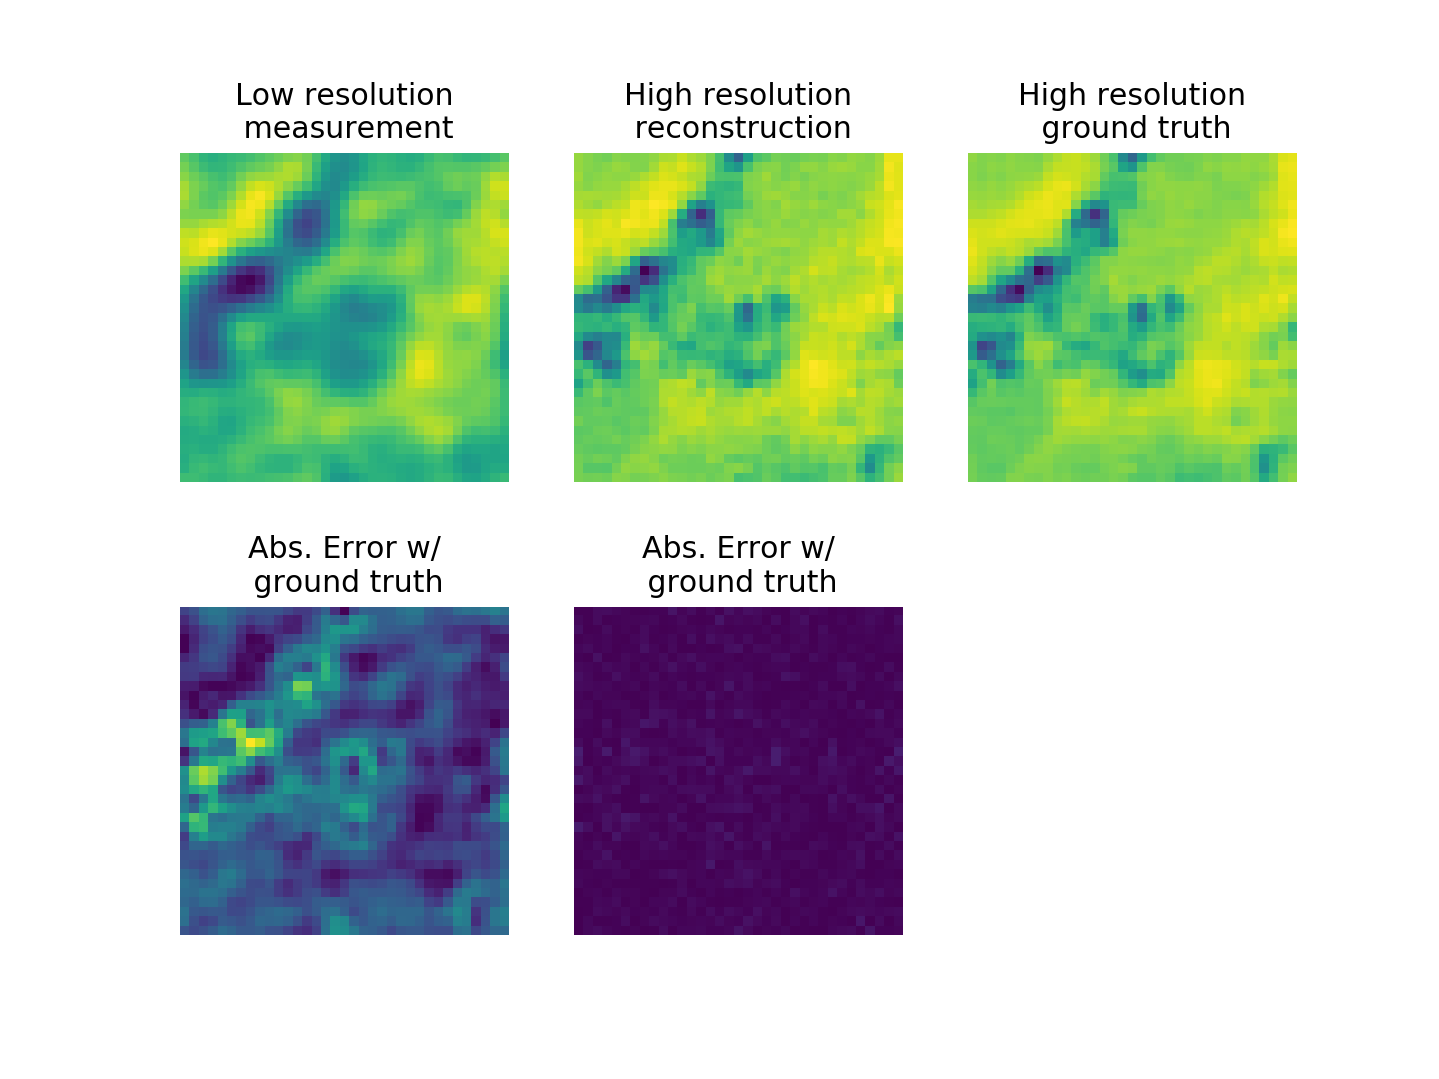

(-0.5, 34.5, 34.5, -0.5)

In [35]:
amp_recon = getAbs(out).cpu().detach().numpy()
plt.figure(figsize=(8,6))
plt.subplot(231)
plt.imshow(measurements[0,:,:].cpu().numpy())
plt.title('Low resolution\n measurement')
plt.axis('off')

plt.subplot(232)
plt.imshow(amp_recon)
plt.title('High resolution\n reconstruction')
plt.axis('off')

plt.subplot(233)
plt.imshow(getAbs(truth).numpy())
plt.title('High resolution\n ground truth')
plt.axis('off')

err1 = np.abs(measurements[0,:,:].cpu().numpy() - getAbs(truth).numpy())
vmax = np.max(err1) 
plt.subplot(234)
plt.imshow(err1,vmax=vmax,vmin=0)
plt.title('Abs. Error w/\n ground truth')
plt.axis('off')

plt.subplot(235)
plt.imshow(np.abs(amp_recon - getAbs(truth).numpy()),vmax=vmax,vmin=0)
plt.title('Abs. Error w/\n ground truth')
plt.axis('off')
